In [ ]:
import pandas as pd
import numpy as np
cars = pd.read_csv("auto.csv")
#cars.columns=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'origin']
cars.head()

In [5]:
#converting cylinder and year to categorical variables:
dummy_cylinders = pd.get_dummies(cars["cylinders"], prefix="cyl")
cars = pd.concat([cars, dummy_cylinders], axis=1)
dummy_years=pd.get_dummies(cars['year'],prefix='year')
cars=pd.concat([cars,dummy_years],axis=1)
cars=cars.drop(['year','cylinders'],axis=1)
cars.head()

,mpg,displacement,horsepower,weight,acceleration,origin,cyl_3,cyl_4,cyl_5,cyl_6,...,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82
0,18.0,307.0,130.0,3504.0,12.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.0,350.0,165.0,3693.0,11.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18.0,318.0,150.0,3436.0,11.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16.0,304.0,150.0,3433.0,12.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17.0,302.0,140.0,3449.0,10.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#shuffling the deck and pick our train and test sets:
shuffled_rows = np.random.permutation(cars.index)
shuffled_cars = cars.iloc[shuffled_rows]
highest_train_row = int(cars.shape[0] * .70)
train = shuffled_cars.iloc[0:highest_train_row]
test = shuffled_cars.iloc[highest_train_row:]

In [9]:
#using one versus all approach to fit three logistic regression models:
from sklearn.linear_model import LogisticRegression

unique_origins = cars["origin"].unique()
unique_origins.sort()

models = {}

features=[c for c in train.columns if c.startswith('cyl') or c.startswith('year')]
for origin in unique_origins:
    model=LogisticRegression()
    
    x_train=train[features]
    y_train=train['origin']==origin
    
    model.fit(x_train,y_train)
    models[origin]=model
    
print(models)

{1: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 2: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 3: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)}


In [11]:
#run our models on test set, and only select the probabilities in a dataframe:
testing_probs = pd.DataFrame(columns=unique_origins)
for origin in unique_origins:
    testing_probs[origin]=models[origin].predict_proba(test[features])[:,1]

testing_probs.head()

,1,2,3
0,0.988213,0.014552,0.004562
1,0.390057,0.305818,0.295173
2,0.889167,0.072300,0.039044
3,0.375672,0.310697,0.305725
4,0.449290,0.286739,0.255170


In [16]:
#using idmax() method of the dataframe to select the origin with the highest probability for each observation. 
# Note: we should set the axis to 1!!
predicted_origins = testing_probs.idxmax(axis=1)
predicted_origins.value_counts()

1    97
3    21
dtype: int64

####  Avoiding Overfitting

In [17]:
cars.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64

Sweet! No missing values!
Now we're going to meassure model's bias and variance with regards to predicting mpg

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def train_and_test(cols):
    features=cars[cols]
    target=cars['mpg']
    model=LinearRegression()
    model.fit(features,target)
    predictions=model.predict(features)
    
    mse=mean_squared_error(target,predictions)
    var=np.var(predictions)
    
    return (mse,var)

#testing out the function
cyl_mse, cyl_var = train_and_test(["cylinders"])
weight_mse, weight_var = train_and_test(["weight"])
cyl_mse

24.02017956815553

In [51]:
two_cols=["cylinders", "displacement"]
three_cols=["cylinders", "displacement", "horsepower"]
four_cols=["cylinders", "displacement", "horsepower", "weight"]
five_cols=["cylinders", "displacement", "horsepower", "weight", "acceleration"]
six_cols=["cylinders", "displacement", "horsepower", "weight", "acceleration", "year"]
seven_cols=["cylinders", "displacement", "horsepower", "weight", "acceleration","year", "origin"]

cols_variation=[["cylinders"],two_cols,three_cols,four_cols,five_cols,six_cols,seven_cols]

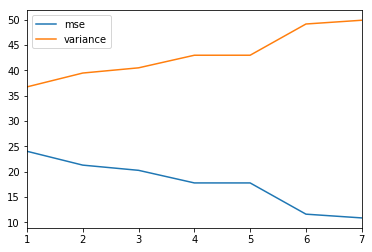

In [53]:
error=pd.DataFrame(columns=['mse','variance'])
i=1
for cols in cols_variation:
    mse,var=train_and_test(cols)
    error.loc[i,'mse']=mse
    error.loc[i,'variance']=var
    i+=1
error.plot()
plt.legend(loc='best')
plt.show()


We dont have a test dataset. But we'd like to compare the in sample error with out-of-sample error. We will use cross validation:

In [61]:
from sklearn.cross_validation import KFold
def train_and_cross_val(cols):
    features=cars[cols]
    target=cars['mpg']
    
    variance_values = []
    mse_values = []
    
    #instance of kFold
    kf = KFold(n=len(cars), n_folds=10, shuffle=True, random_state=3)
    
    #iterate through over each fold
    for train_index, test_index in kf:
        x_train=features.iloc[train_index]
        x_test=features.iloc[test_index]
        
        y_train=target.iloc[train_index]
        y_test=target.iloc[test_index]
        
        model=LinearRegression()
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions)
        var = np.var(predictions)
        
        variance_values.append(var)
        mse_values.append(mse)
    
    avg_mse = np.mean(mse_values)
    avg_var = np.mean(variance_values)
    return(avg_mse, avg_var)     
    

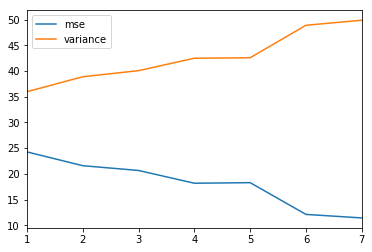

In [66]:
error2=pd.DataFrame(columns=['mse','variance'])
i=1
for cols in cols_variation:
    mse,var=train_and_cross_val(cols)
    error2.loc[i,'mse']=mse
    error2.loc[i,'variance']=var
    i+=1
error2.plot()
plt.legend(loc='best')
plt.show()